# How Debuggers Work

Interactive _debuggers_ are tools that allow you to selectively observe the program state during an execution.  In this chapter, you will learn how such debuggers work – by building your own debugger.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("4aZ0t7CWSjA")

**Prerequisites**

* You should have read the [Chapter on Tracing Executions](Tracer.ipynb).
* Again, knowing a bit of _Python_ is helpful for understanding the code examples in the book.

In [2]:
import bookutils

In [3]:
import sys

In [4]:
from Tracer import Tracer

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Debugger import <identifier>
```

and then make use of the following features.


This chapter provides an interactive debugger for Python functions. The debugger is invoked as

```python
with Debugger():
    function_to_be_observed()
    ...
```
While running, you can enter _debugger commands_ at the `(debugger)` prompt. Here's an example session:

```python
>>> with Debugger():
>>>     ret = remove_html_markup('abc')
Calling remove_html_markup(s = 'abc')

```
<samp>(debugger) <b>help</b></samp>
```
break      -- Set a breakoint in given line. If no line is given, list all breakpoints
continue   -- Resume execution
delete     -- Delete breakoint in line given by `arg`.
           Without given line, clear all breakpoints
help       -- Give help on given `command`. If no command is given, give help on all
list       -- Show current function. If `arg` is given, show its source code.
print      -- Print an expression. If no expression is given, print all variables
quit       -- Finish execution
step       -- Execute up to the next line

```
<samp>(debugger) <b>break 14</b></samp>
```
Breakpoints: {14}

```
<samp>(debugger) <b>list</b></samp>
```
   1> def remove_html_markup(s):  # type: ignore
   2      tag = False
   3      quote = False
   4      out = ""
   5  
   6      for c in s:
   7          if c == '<' and not quote:
   8              tag = True
   9          elif c == '>' and not quote:
  10              tag = False
  11          elif c == '"' or c == "'" and tag:
  12              quote = not quote
  13          elif not tag:
  14#             out = out + c
  15  
  16      return out

```
<samp>(debugger) <b>continue</b></samp>
```
                                         # tag = False, quote = False, out = '', c = 'a'
14             out = out + c

```
<samp>(debugger) <b>step</b></samp>
```
                                         # out = 'a'
6     for c in s:

```
<samp>(debugger) <b>print out</b></samp>
```
out = 'a'

```
<samp>(debugger) <b>quit</b></samp>

The `Debugger` class can be easily extended in subclasses. A new method `NAME_command(self, arg)` will be invoked whenever a command named `NAME` is entered, with `arg` holding given command arguments (empty string if none).

![](PICS/Debugger-synopsis-1.svg)



## Debuggers

_Interactive Debuggers_ (or short *debuggers*) are tools that allow you to observe program executions. A debugger typically offers the following features:

* _Run_ the program
* Define _conditions_ under which the execution should _stop_ and hand over control to the debugger. Conditions include
    * a particular location is reached
    * a particular variable takes a particular value
    * a particular variables is accessed
    * or some other condition of choice.
* When the program stops, you can _observe_ the current state, including
    * the current location
    * variables and their values
    * the current function and its callers
* When the program stops, you can _step_ through program execution, having it stop at the next instruction again.
* Finally, you can also _resume_ execution to the next stop.

This functionality often comes as a _command-line interface_, typing commands at a prompt; or as a _graphical user interface_, selecting commands from the screen. Debuggers can come as standalone tools, or be integrated into a programming environment of choice.

Debugger interaction typically follows a _loop_ pattern. First, you identify the location(s) you want to inspect, and tell the debugger to stop execution once one of these _breakpoints_ is reached. Here's a command that could instruct a command-line debugger to stop at Line 239:

```
(debugger) break 239
(debugger) _
```

Then you have the debugger resume or start execution. The debugger will stop at the given location.

```
(debugger) continue
Line 239: s = x
(debugger) _
```

When it stops at the given location, you use debugger commands to inspect the state (and check whether things are as expected).

```
(debugger) print s
s = 'abc'
(debugger) _
```

You can then step through the program, executing more lines.

```
(debugger) step
Line 240: c = s[0]
(debugger) print c
c = 'a'
(debugger) _
```

You can also define new stop conditions, investigating other locations, variables, and conditions.

## Debugger Interaction

Let us now show how to build such a debugger.  The key idea of an _interactive_ debugger is to set up the _tracing function_ such that it actually _asks_ what to do next, prompting you to enter a _command_. For the sake of simplicity, we collect such a command interactively from a command line, using the Python `input()` function.

Our debugger holds a number of variables to indicate its current status:
* `stepping` is True whenever the user wants to step into the next line.
* `breakpoints` is a set of breakpoints (line numbers)
* `interact` is True while the user stays at one position.

We also store the current tracing information in three attributes `frame`, `event`, and `arg`. The variable `local_vars` holds local variables.

In [5]:
from types import FrameType

In [6]:
# ignore
from typing import Any, Optional, Callable, Dict, List, Tuple, Set, TextIO

In [7]:
class Debugger(Tracer):
    """Interactive Debugger"""

    def __init__(self, *, file: TextIO = sys.stdout) -> None:
        """Create a new interactive debugger."""
        self.stepping: bool = True
        self.breakpoints: Set[int] = set()
        self.interact: bool = True

        self.frame: FrameType
        self.event: Optional[str] = None
        self.arg: Any = None

        self.local_vars: Dict[str, Any] = {}

        super().__init__(file=file)

The `traceit()` method is the main entry point for our debugger. If we should stop, we go into user interaction.

In [8]:
class Debugger(Debugger):
    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function; called at every line. To be overloaded in subclasses."""
        self.frame = frame
        self.local_vars = frame.f_locals  # Dereference exactly once
        self.event = event
        self.arg = arg

        if self.stop_here():
            self.interaction_loop()

We stop whenever we are stepping through the program or reach a breakpoint:

In [9]:
class Debugger(Debugger):
    def stop_here(self) -> bool:
        """Return True if we should stop"""
        return self.stepping or self.frame.f_lineno in self.breakpoints

Our interaction loop shows the current status, reads in commands, and executes them.

In [10]:
class Debugger(Debugger):
    def interaction_loop(self) -> None:
        """Interact with the user"""
        self.print_debugger_status(self.frame, self.event, self.arg)  # type: ignore

        self.interact = True
        while self.interact:
            command = input("(debugger) ")
            self.execute(command)  # type: ignore

For a moment, let us implement two commands, `step` and `continue`. `step` steps through the program:

In [11]:
class Debugger(Debugger):
    def step_command(self, arg: str = "") -> None:
        """Execute up to the next line"""

        self.stepping = True
        self.interact = False

In [12]:
class Debugger(Debugger):
    def continue_command(self, arg: str = "") -> None:
        """Resume execution"""

        self.stepping = False
        self.interact = False

The `execute()` method dispatches between these two.

In [13]:
class Debugger(Debugger):
    def execute(self, command: str) -> None:
        if command.startswith('s'):
            self.step_command()
        elif command.startswith('c'):
            self.continue_command()

Our debugger is now ready to run! Let us invoke it on the buggy `remove_html_markup()` variant from the [Introduction to Debugging](Intro_Debugging.ipynb):

In [14]:
def remove_html_markup(s):  # type: ignore
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

We invoke the debugger just like `Tracer`, using a `with` clause. The code

```python
with Debugger():
    remove_html_markup('abc')
```
gives us a debugger prompt
```
(debugger) _
```
where we can enter one of our two commands.

Let us do two steps through the program and then resume execution:

In [15]:
from bookutils import input, next_inputs

In [16]:
# ignore
next_inputs(["step", "step", "continue"])

['step', 'step', 'continue']

In [17]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


2     tag = False


                                         # tag = False
3     quote = False


In [18]:
# docassert
assert not next_inputs()

Try this out for yourself by running the above invocation in the interactive notebook! If you are reading the Web version, the top menu entry `Resources` -> `Edit as Notebook` will do the trick. Navigate to the above invocation and press `Shift`+`Enter`.

### A Command Dispatcher

Our `execute()` function is still a bit rudimentary. A true command-line tool should provide means to tell which commands are available (`help`), automatically split arguments, and not stand in line of extensibility.

We therefore implement a better `execute()` method which does all that. Our revised `execute()` method _inspects_ its class for methods that end in `_command()`, and automatically registers their names as commands. Hence, with the above, we already get `step` and `continue` as possible commands.

### Excursion: Implementing execute()

Let us detail how we implement `execute()`. The `commands()` method returns a list of all commands (as strings) from the class.

In [19]:
class Debugger(Debugger):
    def commands(self) -> List[str]:
        """Return a list of commands"""

        cmds = [method.replace('_command', '')
                for method in dir(self.__class__)
                if method.endswith('_command')]
        cmds.sort()
        return cmds

In [20]:
d = Debugger()
d.commands()

['continue', 'step']

The `command_method()` method converts a given command (or its abbrevation) into a method to be called.

In [21]:
class Debugger(Debugger):
    def help_command(self, command: str) -> None:
        ...

    def command_method(self, command: str) -> Optional[Callable[[str], None]]:
        """Convert `command` into the method to be called.
           If the method is not found, return `None` instead."""

        if command.startswith('#'):
            return None  # Comment

        possible_cmds = [possible_cmd for possible_cmd in self.commands()
                         if possible_cmd.startswith(command)]
        if len(possible_cmds) != 1:
            self.help_command(command)
            return None

        cmd = possible_cmds[0]
        return getattr(self, cmd + '_command')

In [22]:
d = Debugger()
d.command_method("step")

<bound method Debugger.step_command of <__main__.Debugger object at 0x105db8100>>

In [23]:
d = Debugger()
d.command_method("s")

<bound method Debugger.step_command of <__main__.Debugger object at 0x105db8be0>>

The revised `execute()` method now determines this method and executes it with the given argument.

In [24]:
class Debugger(Debugger):
    def execute(self, command: str) -> None:
        """Execute `command`"""

        sep = command.find(' ')
        if sep > 0:
            cmd = command[:sep].strip()
            arg = command[sep + 1:].strip()
        else:
            cmd = command.strip()
            arg = ""

        method = self.command_method(cmd)
        if method:
            method(arg)

If `command_method()` cannot find the command, or finds more than one matching the prefix, it invokes the `help` command providing additional assistance. `help` draws extra info on each command from its documentation string.

In [25]:
class Debugger(Debugger):
    def help_command(self, command: str = "") -> None:
        """Give help on given `command`. If no command is given, give help on all"""

        if command:
            possible_cmds = [possible_cmd for possible_cmd in self.commands()
                             if possible_cmd.startswith(command)]

            if len(possible_cmds) == 0:
                self.log(f"Unknown command {repr(command)}. Possible commands are:")
                possible_cmds = self.commands()
            elif len(possible_cmds) > 1:
                self.log(f"Ambiguous command {repr(command)}. Possible expansions are:")
        else:
            possible_cmds = self.commands()

        for cmd in possible_cmds:
            method = self.command_method(cmd)
            self.log(f"{cmd:10} -- {method.__doc__}")

In [26]:
d = Debugger()
d.execute("help")

continue   -- Resume execution
help       -- Give help on given `command`. If no command is given, give help on all
step       -- Execute up to the next line


In [27]:
d = Debugger()
d.execute("foo")

Unknown command 'foo'. Possible commands are:
continue   -- Resume execution
help       -- Give help on given `command`. If no command is given, give help on all
step       -- Execute up to the next line


### End of Excursion

## Printing Values

With `execute()`, we can now easily extend our class – all it takes is for a new command `NAME` is a new `NAME_command()` method. Let us start by providing a `print` command to print all variables. We use similar code as for the `Tracer` class in the [chapter on tracing](Tracer.ipynb).

In [28]:
class Debugger(Debugger):
    def print_command(self, arg: str = "") -> None:
        """Print an expression. If no expression is given, print all variables"""

        vars = self.local_vars
        self.log("\n".join([f"{var} = {repr(value)}" for var, value in vars.items()]))

In [29]:
# ignore
next_inputs(["step", "step", "step", "print", "continue"]);

In [30]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


2     tag = False


                                         # tag = False
3     quote = False


                                         # quote = False
4     out = ""


s = 'abc'
tag = False
quote = False


In [31]:
# docassert
assert not next_inputs()

Let us extend `print` such that if an argument is given, it only evaluates and prints out this argument.

In [32]:
class Debugger(Debugger):
    def print_command(self, arg: str = "") -> None:
        """Print an expression. If no expression is given, print all variables"""

        vars = self.local_vars

        if not arg:
            self.log("\n".join([f"{var} = {repr(value)}" for var, value in vars.items()]))
        else:
            try:
                self.log(f"{arg} = {repr(eval(arg, globals(), vars))}")
            except Exception as err:
                self.log(f"{err.__class__.__name__}: {err}")

In [33]:
# ignore
next_inputs(["p s", "c"]);

In [34]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


s = 'abc'


In [35]:
# docassert
assert not next_inputs()

Note how we would abbreviate commands to speed things up. The argument to `print` can be any Python expression:

In [36]:
# ignore
next_inputs(["print (s[0], 2 + 2)", "continue"]);

In [37]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


(s[0], 2 + 2) = ('a', 4)


Our `help` command also properly lists `print` as a possible command:

In [38]:
# ignore
next_inputs(["help print", "continue"]);

In [39]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


print      -- Print an expression. If no expression is given, print all variables


In [40]:
# docassert
assert not next_inputs()

## Listing Source Code

We implement a `list` command that shows the source code of the current function.

In [41]:
import inspect

In [42]:
from bookutils import getsourcelines  # like inspect.getsourcelines(), but in color

In [43]:
class Debugger(Debugger):
    def list_command(self, arg: str = "") -> None:
        """Show current function."""

        source_lines, line_number = getsourcelines(self.frame.f_code)

        for line in source_lines:
            self.log(f'{line_number:4} {line}', end='')
            line_number += 1

In [44]:
# ignore
next_inputs(["list", "continue"]);

In [45]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


   1 def remove_html_markup(s):  # type: ignore
   2     tag = False
   3     quote = False
   4     out = ""
   5 
   6     for c in s:
   7         if c == '<' and not quote:
   8             tag = True
   9         elif c == '>' and not quote:
  10             tag = False
  11         elif c == '"' or c == "'" and tag:
  12             quote = not quote
  13         elif not tag:
  14             out = out + c
  15 
  16     return out


In [46]:
# docassert
assert not next_inputs()

## Setting Breakpoints

Stepping through the program line by line is a bit cumbersome. We therefore implement _breakpoints_ – a set of lines that cause the program to be interrupted as soon as this line is met.

In [47]:
class Debugger(Debugger):
    def break_command(self, arg: str = "") -> None:
        """Set a breakoint in given line. If no line is given, list all breakpoints"""

        if arg:
            self.breakpoints.add(int(arg))
        self.log("Breakpoints:", self.breakpoints)

Here's an example, setting a breakpoint at the end of the loop:

In [48]:
# ignore
_, remove_html_markup_starting_line_number = \
    inspect.getsourcelines(remove_html_markup)
next_inputs([f"break {remove_html_markup_starting_line_number + 13}",
             "continue", "print", "continue", "continue", "continue"]);

In [49]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


Breakpoints: {14}


                                         # tag = False, quote = False, out = '', c = 'a'
14             out = out + c


s = 'abc'
tag = False
quote = False
out = ''
c = 'a'


                                         # out = 'a', c = 'b'
14             out = out + c


                                         # out = 'ab', c = 'c'
14             out = out + c


In [50]:
# docassert
assert not next_inputs()

In [51]:
from bookutils import quiz

In [52]:
quiz("What happens if we enter the command `break 2 + 3`?",
     [
         "A breakpoint is set in Line 2.",
         "A breakpoint is set in Line 5.",
         "Two breakpoints are set in Lines 2 and 3.",
         "The debugger raises a `ValueError` exception."
     ], '12345 % 7')

Try it out yourself by executing the above code block!

## Deleting Breakpoints

To delete breakpoints, we introduce a `delete` command:

In [53]:
class Debugger(Debugger):
    def delete_command(self, arg: str = "") -> None:
        """Delete breakoint in line given by `arg`.
           Without given line, clear all breakpoints"""

        if arg:
            try:
                self.breakpoints.remove(int(arg))
            except KeyError:
                self.log(f"No such breakpoint: {arg}")
        else:
            self.breakpoints = set()
        self.log("Breakpoints:", self.breakpoints)

In [54]:
# ignore
next_inputs([f"break {remove_html_markup_starting_line_number + 15}",
             "continue", "print",
             f"delete {remove_html_markup_starting_line_number + 15}",
             "continue"]);

In [55]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


Breakpoints: {16}


                                         # tag = False, quote = False, out = 'abc', c = 'c'
16     return out


s = 'abc'
tag = False
quote = False
out = 'abc'
c = 'c'


Breakpoints: set()


In [56]:
# docassert
assert not next_inputs()

In [57]:
quiz("What does the command `delete` (without argument) do?",
    [
        "It deletes all breakpoints",
        "It deletes the source code",
        "It lists all breakpoints",
        "It stops execution"
    ],
    '[n for n in range(2 // 2, 2 * 2) if n % 2 / 2]'
    )

## Listings with Benefits

Let us extend `list` a bit such that 

1. it can also list a given function, and 
2. it shows the current line (`>`) as well as breakpoints (`#`)

In [58]:
class Debugger(Debugger):
    def list_command(self, arg: str = "") -> None:
        """Show current function. If `arg` is given, show its source code."""

        try:
            if arg:
                obj = eval(arg)
                source_lines, line_number = inspect.getsourcelines(obj)
                current_line = -1
            else:
                source_lines, line_number = \
                    getsourcelines(self.frame.f_code)
                current_line = self.frame.f_lineno
        except Exception as err:
            self.log(f"{err.__class__.__name__}: {err}")
            source_lines = []
            line_number = 0

        for line in source_lines:
            spacer = ' '
            if line_number == current_line:
                spacer = '>'
            elif line_number in self.breakpoints:
                spacer = '#'
            self.log(f'{line_number:4}{spacer} {line}', end='')
            line_number += 1

In [59]:
# ignore
_, remove_html_markup_starting_line_number = \
    inspect.getsourcelines(remove_html_markup)
next_inputs([f"break {remove_html_markup_starting_line_number + 13}",
             "list", "continue", "delete", "list", "continue"]);

In [60]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


Breakpoints: {14}


   1> def remove_html_markup(s):  # type: ignore
   2      tag = False
   3      quote = False
   4      out = ""
   5  
   6      for c in s:
   7          if c == '<' and not quote:
   8              tag = True
   9          elif c == '>' and not quote:
  10              tag = False
  11          elif c == '"' or c == "'" and tag:
  12              quote = not quote
  13          elif not tag:
  14#             out = out + c
  15  
  16      return out


                                         # tag = False, quote = False, out = '', c = 'a'
14             out = out + c


Breakpoints: set()


   1  def remove_html_markup(s):  # type: ignore
   2      tag = False
   3      quote = False
   4      out = ""
   5  
   6      for c in s:
   7          if c == '<' and not quote:
   8              tag = True
   9          elif c == '>' and not quote:
  10              tag = False
  11          elif c == '"' or c == "'" and tag:
  12              quote = not quote
  13          elif not tag:
  14>             out = out + c
  15  
  16      return out


In [61]:
# docassert
assert not next_inputs()

### Quitting

In the Python debugger interface, we can only observe, but not alter the control flow. To make sure we can always exit out of our debugging session, we introduce a `quit` command that deletes all breakpoints and resumes execution until the observed function finishes.

In [62]:
class Debugger(Debugger):
    def quit_command(self, arg: str = "") -> None:
        """Finish execution"""

        self.breakpoints = set()
        self.stepping = False
        self.interact = False

With this, our command palette is pretty complete, and we can use our debugger to happily inspect Python executions.

In [63]:
# ignore
next_inputs(["help", "quit"]);

In [64]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


break      -- Set a breakoint in given line. If no line is given, list all breakpoints
continue   -- Resume execution
delete     -- Delete breakoint in line given by `arg`.
           Without given line, clear all breakpoints
help       -- Give help on given `command`. If no command is given, give help on all
list       -- Show current function. If `arg` is given, show its source code.
print      -- Print an expression. If no expression is given, print all variables
quit       -- Finish execution
step       -- Execute up to the next line


In [65]:
# docassert
assert not next_inputs()

## Synopsis

This chapter provides an interactive debugger for Python functions. The debugger is invoked as

```python
with Debugger():
    function_to_be_observed()
    ...
```
While running, you can enter _debugger commands_ at the `(debugger)` prompt. Here's an example session:

In [66]:
# ignore
_, remove_html_markup_starting_line_number = \
    inspect.getsourcelines(remove_html_markup)
next_inputs(["help", f"break {remove_html_markup_starting_line_number + 13}",
             "list", "continue", "step", "print out", "quit"])
pass

In [67]:
with Debugger():
    ret = remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


break      -- Set a breakoint in given line. If no line is given, list all breakpoints
continue   -- Resume execution
delete     -- Delete breakoint in line given by `arg`.
           Without given line, clear all breakpoints
help       -- Give help on given `command`. If no command is given, give help on all
list       -- Show current function. If `arg` is given, show its source code.
print      -- Print an expression. If no expression is given, print all variables
quit       -- Finish execution
step       -- Execute up to the next line


Breakpoints: {14}


   1> def remove_html_markup(s):  # type: ignore
   2      tag = False
   3      quote = False
   4      out = ""
   5  
   6      for c in s:
   7          if c == '<' and not quote:
   8              tag = True
   9          elif c == '>' and not quote:
  10              tag = False
  11          elif c == '"' or c == "'" and tag:
  12              quote = not quote
  13          elif not tag:
  14#             out = out + c
  15  
  16      return out


                                         # tag = False, quote = False, out = '', c = 'a'
14             out = out + c


                                         # out = 'a'
6     for c in s:


out = 'a'


In [68]:
# docassert
assert not next_inputs()

The `Debugger` class can be easily extended in subclasses. A new method `NAME_command(self, arg)` will be invoked whenever a command named `NAME` is entered, with `arg` holding given command arguments (empty string if none).

In [69]:
# ignore
from ClassDiagram import display_class_hierarchy

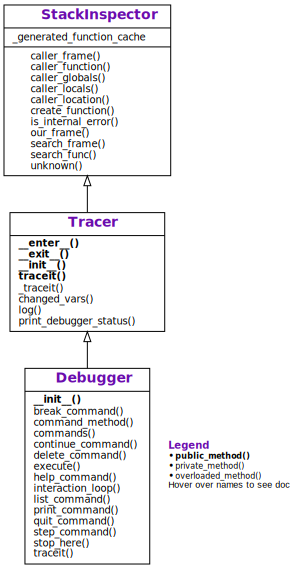

In [70]:
# ignore
display_class_hierarchy(Debugger, 
                        public_methods=[
                            Tracer.__init__,
                            Tracer.__enter__,
                            Tracer.__exit__,
                            Tracer.traceit,
                            Debugger.__init__,
                        ],
    project='debuggingbook')

## Lessons Learned

* _Debugging hooks_ from interpreted languages allow for simple interactive debugging.
* A command-line debugging framework can be very easily extended with additional functionality.

## Next Steps

In the next chapter, we will see how [assertions](Assertions.ipynb) check correctness at runtime.

## Background

The command-line interface in this chapter is modeled after [GDB, the GNU debugger](https://www.gnu.org/software/gdb/), whose interface in turn goes back to earlier command-line debuggers such as [dbx](https://en.wikipedia.org/wiki/Dbx_%28debugger%29). All modern debuggers build on the functionality and concepts realized in these debuggers, be it breakpoints,  stepping through programs, or inspecting program state.

The concept of time travel debugging (see the Exercises, below) has been invented (and reinvented) many times. One of the most impactful tools comes from King et al. \cite{King2005}, integrating _a time-traveling virtual machine_ (TTVM) for debugging operating systems, integrated into GDB. The recent [record+replay "rr" debugger](https://rr-project.org) also implements time travel debugging on top of the GDB command line debugger; it is applicable for general-purpose programs and available as open source.

## Exercises


### Exercise 1: Changing State

Some Python implementations allow to alter the state, by assigning values to `frame.f_locals`. Implement a `assign VAR=VALUE` command that allows to change the value of (local) variable `VAR` to the new value `VALUE`.

Note: As detailed in [this blog post](https://utcc.utoronto.ca/~cks/space/blog/python/FLocalsAndTraceFunctions), 
`frame.f_locals` is re-populated with every access, so assign to our local alias `self.local_vars` instead.

**Solution.** Here is an `assign` command that gets things right on CPython.

In [71]:
class Debugger(Debugger):
    def assign_command(self, arg: str) -> None:
        """Use as 'assign VAR=VALUE'. Assign VALUE to local variable VAR."""

        sep = arg.find('=')
        if sep > 0:
            var = arg[:sep].strip()
            expr = arg[sep + 1:].strip()
        else:
            self.help_command("assign")
            return

        vars = self.local_vars
        try:
            vars[var] = eval(expr, self.frame.f_globals, vars)
        except Exception as err:
            self.log(f"{err.__class__.__name__}: {err}")

In [72]:
# ignore
next_inputs(["assign s = 'xyz'", "print", "step", "print", "step",
             "assign tag = True", "assign s = 'abc'", "print",
             "step", "print", "continue"]);

In [73]:
with Debugger():
    remove_html_markup('abc')

Calling remove_html_markup(s = 'abc')


s = 'xyz'


                                         # s = 'xyz'
2     tag = False


s = 'xyz'


                                         # tag = False
3     quote = False


s = 'abc'
tag = True


                                         # s = 'abc', tag = True, quote = False
4     out = ""


s = 'abc'
tag = True
quote = False


In [74]:
# docassert
assert not next_inputs()

### Exercise 2: More Commands

Extending the `Debugger` class with extra features and commands is a breeze. The following commands are inspired from [the GNU command-line debugger (GDB)](https://www.gnu.org/software/gdb/):

#### Named breakpoints ("break")

With `break FUNCTION` and `delete FUNCTION`, set and delete a breakpoint at `FUNCTION`.

#### Step over functions ("next")

When stopped at a function call, the `next` command should execute the entire call, stopping when the function returns. (In contrast, `step` stops at the first line of the function called.)

#### Print call stack ("where")

Implement a `where` command that shows the stack of calling functions.

#### Move up and down the call stack ("up" and "down")

After entering the `up` command, explore the source and variables of the _calling_ function rather than the current function. Use `up` repeatedly to move further up the stack. `down` returns to the caller.

#### Execute until line ("until")

With `until LINE`, resume execution until a line greater than `LINE` is reached. If `LINE` is not given, resume execution until a line greater than the current is reached. This is useful to avoid stepping through multiple loop iterations.

#### Execute until return ("finish")

With `finish`, resume execution until the current function returns.

#### Watchpoints ("watch")

With `watch CONDITION`, stop execution as soon as `CONDITION` changes its value. (Use the code from our `EventTracer` class in the [chapter on Tracing](Tracer.ipynb).) `delete CONDITION` removes the watchpoint. Keep in mind that some variable names may not exist at all times.

### Exercise 3: Time-Travel Debugging

Rather than inspecting a function at the moment it executes, you can also _record_ the entire state (call stack, local variables, etc.) during execution, and then run an interactive session to step through the recorded execution. Your time travel debugger would be invoked as

```python
with TimeTravelDebugger():
    function_to_be_tracked()
    ...
```

The interaction then starts at the end of the `with` block.

#### Part 1: Recording Values

Start with a subclass of `Tracer` from the [chapter on tracing](Tracer.ipynb) (say, `TimeTravelTracer`) to execute a program while recording all values. Keep in mind that recording even only local variables at each step quickly consumes large amounts of memory. As an alternative, consider recording only _changes_ to variables, with the option to restore an entire state from a baseline and later changes.

#### Part 2: Command Line Interface

Create `TimeTravelDebugger` as subclass of both `TimeTravelTracer` and `Debugger` to provide a command line interface as with `Debugger`, including additional commands which get you back to earlier states:

* `back` is like `step`, except that you go one line back
* `restart` gets you to the beginning of the execution
* `rewind` gets you to the beginning of the current function invocation

#### Part 3: Graphical User Interface

Create `GUItimeTravelDebugger` to provide a _graphical user interface_ that allows you to explore a recorded execution, using HTML and JavaScript.

Here's a simple example to get you started. Assume you have recorded the following line numbers and variable values:

In [75]:
recording: List[Tuple[int, Dict[str, Any]]] = [
    (10, {'x': 25}),
    (11, {'x': 25}),
    (12, {'x': 26, 'a': "abc"}),
    (13, {'x': 26, 'a': "abc"}),
    (10, {'x': 30}),
    (11, {'x': 30}),
    (12, {'x': 31, 'a': "def"}),
    (13, {'x': 31, 'a': "def"}),
    (10, {'x': 35}),
    (11, {'x': 35}),
    (12, {'x': 36, 'a': "ghi"}),
    (13, {'x': 36, 'a': "ghi"}),
]

Then, the following function will provide a _slider_ that will allow you to explore these values:

In [76]:
from bookutils import HTML

In [77]:
def slider(rec: List[Tuple[int, Dict[str, Any]]]) -> str:
    lines_over_time = [line for (line, var) in rec]
    vars_over_time = []
    for (line, vars) in rec:
        vars_over_time.append(", ".join(f"{var} = {repr(value)}"
                                        for var, value in vars.items()))

    # print(lines_over_time)
    # print(vars_over_time)

    template = f'''
    <div class="time_travel_debugger">
      <input type="range" min="0" max="{len(lines_over_time) - 1}"
      value="0" class="slider" id="time_slider">
      Line <span id="line">{lines_over_time[0]}</span>:
      <span id="vars">{vars_over_time[0]}</span>
    </div>
    <script>
       var lines_over_time = {lines_over_time};
       var vars_over_time = {vars_over_time};

       var time_slider = document.getElementById("time_slider");
       var line = document.getElementById("line");
       var vars = document.getElementById("vars");

       time_slider.oninput = function() {{
          line.innerHTML = lines_over_time[this.value];
          vars.innerHTML = vars_over_time[this.value];
       }}
    </script>
    '''
    # print(template)
    return HTML(template)

In [78]:
slider(recording)

Explore the HTML and JavaScript details of how `slider()` works, and then expand it to a user interface where you can

* see the current source code (together with the line being executed)
* search for specific events, such as a line being executed or a variable changing its value

Just like `slider()`, your user interface should come in pure HTML and JavaScript such that it can run in a browser (or a Jupyter notebook) without interacting with a Python program.